## 

### Benchmark SWAP test for state overlap

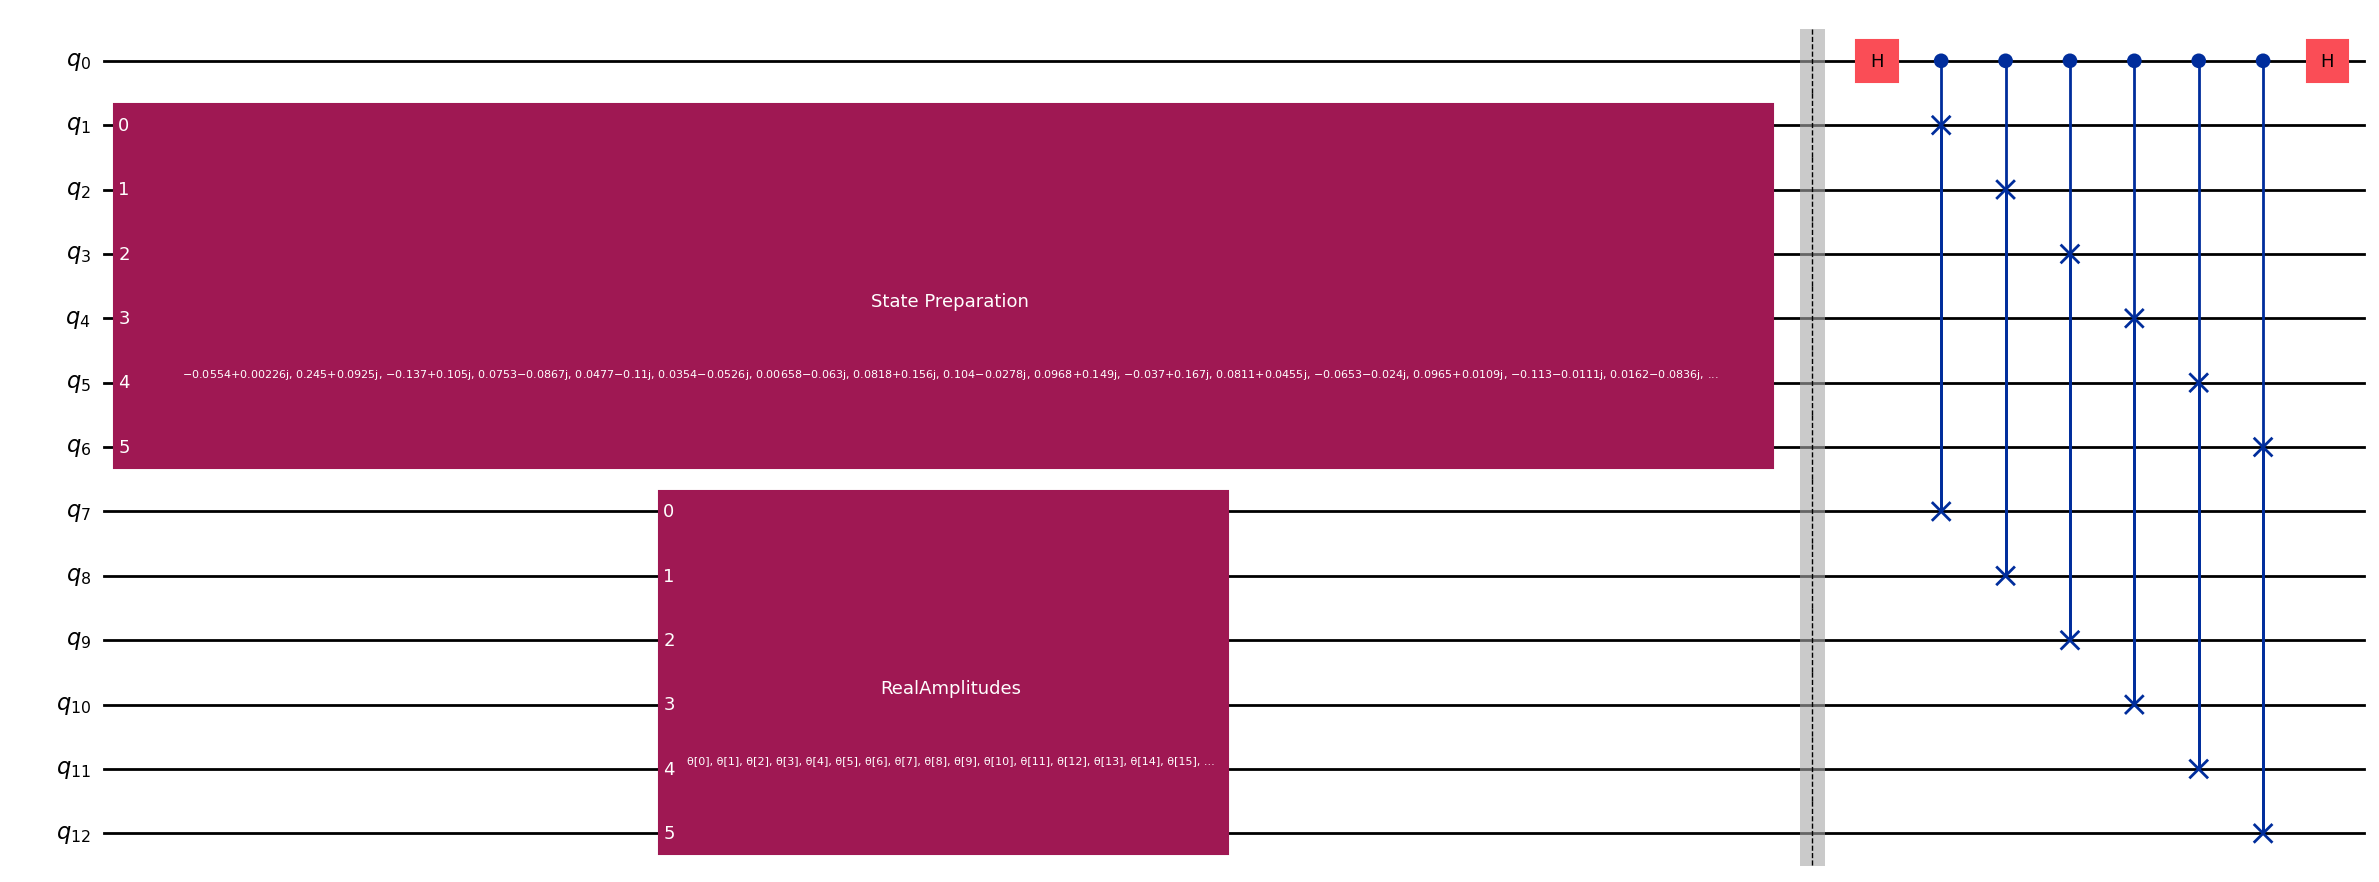

In [4]:
import hadamard_random_forest as hrf
from qiskit.circuit.library import RealAmplitudes
import numpy as np

def random_state(num_qubits: int) -> np.ndarray:
    """Generate a random normalized statevector of length 2**num_qubits."""
    dim = 2**num_qubits
    # real and imaginary parts ∼ N(0,1)
    vec = np.random.randn(dim) + 1j * np.random.randn(dim)
    return vec / np.linalg.norm(vec)


# Example for 3 qubits:
num_qubits = 6
num_layers = 4
psi1 = random_state(num_qubits)
# psi2 = random_state(num_qubits)
ansatz = RealAmplitudes(num_qubits, entanglement='pairwise', reps=num_layers, skip_final_rotation_layer=True)
psi2 = ansatz

# Build the SWAP-test circuit
qc = hrf.swap_test(psi1, psi2)

# Inspect the circuit
qc.draw("mpl", fold=-1)